# Energy function fitting with AR-DAE
Partial implementation of the paper "AR-DAE: Towards Unbiased Neural Entropy Gradient Estimation"



## 1. imports and helper functions



In [0]:
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

def regularization_func(x):
    return (torch.relu(x.abs() - 6) ** 2).sum(-1, keepdim=True)

def w1(z1):
    return torch.sin(2.*math.pi*z1/4.)

def w2(z1):
    return 3.*torch.exp(-0.5*((z1-1)/0.6)**2)

def w3(z1):
    return 3.*torch.sigmoid((z1-1.)/0.3)

def energy_func4(x):
    assert x.dim() == 2
    assert x.size(1) == 2
    batch_size = x.size(0)
    x1 = x[:, :1]
    x2 = x[:, 1:]

    energy = -torch.log(
            torch.exp(-0.5 * ((x2-w1(x1))/0.4)**2)
            + torch.exp(-0.5 * ((x2-w1(x1)+w3(x1))/0.35)**2)
            + 1e-9)
    return energy + regularization_func(x)

def annealing_func(val_init, val_fin, val_annealing, step):
    val = val_init + (val_fin  - val_init)  / float(val_annealing)  * float(min(val_annealing, step)) if val_annealing is not None else val_fin
    return float(val)

from torch.optim.lr_scheduler import _LRScheduler
class StepLR(_LRScheduler):
    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1, min_lr=None):
        self.step_size = step_size
        self.gamma = gamma
        self.min_lr = min_lr
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [max(self.min_lr, base_lr * self.gamma ** (self.last_epoch // self.step_size))
                for base_lr in self.base_lrs]

## 2. Define AR-DAE and generator

In [0]:
class resARDAE(nn.Module):
    def __init__(self,
                 input_dim=2,
                 hidden_dim=64,
                 ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(                                                                                            
            nn.Linear(input_dim+1, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, input_dim)
            )

    def add_noise(self, input, std):
        eps = torch.randn_like(input)
        return input + std*eps, eps

    def loss(self, input, target):
        recon_loss = F.mse_loss(input, target)
        return recon_loss

    def forward(self, input, std):
        input = input.view(-1, self.input_dim)
        assert torch.is_tensor(std)
        x_bar, eps = self.add_noise(input, std) # add noise
        h = torch.cat([x_bar, std], dim=1) # concat
        glogprob = self.main(h) # predict
        loss = self.loss(std*glogprob, -eps) # loss
        # return
        return glogprob, loss

    def glogprob(self, input, std):
        input = input.view(-1, self.input_dim)
        assert torch.is_tensor(std)
        h = torch.cat([input, std], dim=1) # concat
        glogprob = self.main(h) # predict
        return glogprob

class Generator(nn.Module):
    def __init__(self,
                 input_dim=2,
                 hidden_dim=64,
                 z_dim=2,
                 ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim

        self.main = nn.Sequential(                                                                                            
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
            )

    def sample_noise(self, batch_size):
        weight = next(self.parameters())
        device = weight.device
        eps = torch.randn(batch_size, self.z_dim).to(device)
        return eps

    def loss(self, x):
        loss = torch.mean(energy_func(x)) # loss from energy func
        return loss

    def forward(self, batch_size=None):
        batch_size = 128 if batch_size is None else batch_size
        z = self.sample_noise(batch_size) # sample z
        x = self.main(z) # forward
        loss = self.loss(x) # loss
        return x, loss

## 3. init hyperparameters

In [0]:
# data and env
energy_func = energy_func4
device = torch.device('cuda')

# models
input_dim = 2 # dim of input
z_dim = 10 # dim of source noise 

# training
num_dae_updates = 2 #5 # number of dae updates per one gen update
num_sigma = 10 # number of noise scale samples
lr = 0.001 # learning rate
iterations = 50000 #100000 # number of iterations
batch_size = 1024 # mini-batch size
log_interval = 5000 # log interval

## 4. init models

In [0]:
model = Generator(
        input_dim=input_dim,
        hidden_dim=256,
        z_dim=z_dim,
        ).to(device)
model_optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
model_scheduler = StepLR(model_optimizer, step_size=5000, gamma=0.5, min_lr=1e-10)

dae = resARDAE(
        input_dim=input_dim,
        hidden_dim=256,
        ).to(device)
dae_optimizer = optim.RMSprop(dae.parameters(), lr=lr, momentum=0.5)

## 5. training

In [39]:
start_time = time.time()
for i_ep in range(iterations):
    # init
    alpha = annealing_func(0.01, 1.0, 20000, i_ep)
    delta = 0.1 #annealing_func(1.0,  0.1, 20000, i_ep)
    
    ''' dae update '''
    # init model and dae
    model.eval()
    dae.train()
    for i in range(num_dae_updates):
        # init grad
        dae_optimizer.zero_grad()

        # forward
        output, _ = model(batch_size)

        # est sigma
        sigma = delta*torch.randn(batch_size*num_sigma, 1, device=device) # 1 x 1

        # forward
        _output = output.detach().unsqueeze(1).expand(batch_size, num_sigma, input_dim).reshape(batch_size*num_sigma, input_dim) 
        _, dae_loss = dae(_output, std=sigma)

        # backward
        dae_loss.backward()

        # update
        dae_optimizer.step()

    ''' update model '''
    # init model and dae
    model.train()
    dae.eval()

    # init grad
    model_optimizer.zero_grad()

    # forward
    output, model_loss = model(batch_size)

    # backward
    (0+alpha*model_loss).backward(retain_graph=True)

    # aux_loss with dae forward and backward
    sigma = torch.zeros(batch_size, 1, device=device) # bsz x 1
    grad = dae.glogprob(output.detach(), std=sigma) # -loglikelihood
    output.backward(grad.detach()/float(batch_size))

    # update
    model_optimizer.step()
    model_scheduler.step()

    ''' print '''
    if (i_ep+1) % log_interval == 0:
        elapsed = time.time() - start_time # set log info
        print('| {:5d}/{:5d} | ms/step {:5.2f} | delta {:5.3f} | alpha {:5.3f} '
              '| loss (model) {:5.3f} | loss (dae) {:5.3f} '
              .format(
              i_ep+1, iterations, elapsed * 1000 / log_interval, delta, alpha,
              model_loss.item(), dae_loss.item(),
              )) 
        start_time = time.time() # reset log info

|  5000/50000 | ms/step 27.62 | delta 0.100 | alpha 0.257 | loss (model) 2.039 | loss (dae) 0.974 
| 10000/50000 | ms/step 27.84 | delta 0.100 | alpha 0.505 | loss (model) 0.607 | loss (dae) 0.957 
| 15000/50000 | ms/step 27.95 | delta 0.100 | alpha 0.752 | loss (model) 0.197 | loss (dae) 0.944 
| 20000/50000 | ms/step 28.00 | delta 0.100 | alpha 1.000 | loss (model) 0.207 | loss (dae) 0.946 
| 25000/50000 | ms/step 27.99 | delta 0.100 | alpha 1.000 | loss (model) 0.212 | loss (dae) 0.926 
| 30000/50000 | ms/step 28.12 | delta 0.100 | alpha 1.000 | loss (model) 0.297 | loss (dae) 0.936 
| 35000/50000 | ms/step 28.13 | delta 0.100 | alpha 1.000 | loss (model) 0.199 | loss (dae) 0.942 
| 40000/50000 | ms/step 28.10 | delta 0.100 | alpha 1.000 | loss (model) 0.220 | loss (dae) 0.936 
| 45000/50000 | ms/step 28.20 | delta 0.100 | alpha 1.000 | loss (model) 0.203 | loss (dae) 0.940 
| 50000/50000 | ms/step 28.17 | delta 0.100 | alpha 1.000 | loss (model) 0.178 | loss (dae) 0.947 


## 6. visualize

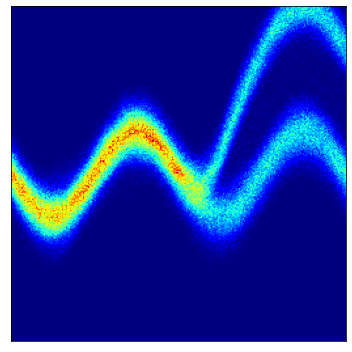

In [40]:
''' visualize '''
def get_2d_histogram_plot(data):
    # get histogram
    heatmap, xedges, yedges = np.histogram2d(
        data[:, 0],
        data[:, 1],
        range=[[-4, 4], [-4, 4]],
        bins=256,
        )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # plot heatmap
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(heatmap.T, extent=extent, cmap='jet')
    ax.grid(False)
    plt.xticks([])
    plt.yticks([])

    # tight
    plt.tight_layout()

# scatter
outputs = []
for i in range(int(1000000//batch_size)+1):
    output, _ = model(batch_size)
    outputs += [output.detach()]
output = torch.cat(outputs, dim=0).cpu()
get_2d_histogram_plot(output.numpy())